# Data
In google My Drive I have:

- Flickr8k_Dataset.zip
- Flickr8k_text.zip
- glove.6B.zip

Then, you should be able to run through the notebook as is..  

This is based on https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8 at the AT3 suggested models

# Mounting the Drive
The zipped image and text files are stored in Google My Drive, so first the drive is mounted and then the files are downloaded, accessible in /root/.keras/datasets/

In [1]:
%tensorflow_version 2.x
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Read the Images to Keras/datasets
import tensorflow as tf
file_url = 'file:///content/drive/My Drive/Flickr8k_Dataset.zip'
zip_dir = tf.keras.utils.get_file('Flickr8k_Dataset.zip', origin=file_url, extract=True)
print(zip_dir)

# Read the Text files
import tensorflow as tf
file_url = 'file:///content/drive/My Drive/Flickr8k_text.zip'
txt_dir = tf.keras.utils.get_file('Flickr8k_text.zip', origin=file_url, extract=True)
print(txt_dir)

# Read the Text files
import tensorflow as tf
file_url = 'file:///content/drive/My Drive/glove.6B.zip'
glv_dir = tf.keras.utils.get_file('glove.6B.zip', origin=file_url, extract=True)
print(glv_dir)


1115422720/1115419746 [==============================] - 26s 0us/step
/root/.keras/datasets/Flickr8k_Dataset.zip
2342912/2340801 [==============================] - 1s 0us/step
/root/.keras/datasets/Flickr8k_text.zip
862183424/862182613 [==============================] - 44s 0us/step
/root/.keras/datasets/glove.6B.zip


In [0]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
import pickle #import dump, load
from time import time
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, add, Add, concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Loading the Data and Cleaning
Read the token file which contains the captions for each image.  There are 5 captions per image.  The structure of the file is:
- ![alt text](https://)filename#Caption number (0-4)[TAB]Caption

For example:

`1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .`

In [0]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

root_directory = '/root/.keras/datasets/'
filename = root_directory + "Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)

Then read in the text and split out the filename and description separately.  This goes into a dictionary where the key is the filename and the 5 desciptions are added as the item.


In [5]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


Clean the text by:
- Removing punctuation
- making everything lower case
- remove hanging 's' and 'a'
- remove numbers

In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

Now create a vocabulary of words, so take the descriptions and make a list of unique words.

In [7]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


Then save the descriptions to file.

In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

# Load the Images
trainImages.txt contains the filenames that are to be used for training.  This file is read in, the filetype is stripped off and the filename is saved to a list.

In [9]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = root_directory +  'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


Then save a list of images, ready for loading.

In [0]:
# Below path contains all the images
images = root_directory + 'Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

Now load the set of train image filenames to a list and the set of test image filename to another in preparation of loading the images.

In [0]:
# Below file conatains the names of images to be used in train data
train_images_file = root_directory + 'Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [0]:
# Below file conatains the names of images to be used in test data
test_images_file = root_directory + 'Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

Load the training descriptions from the file of descriptions created earlier. 'startseq' is added before the caption to denote the start of the sentence and 'endseq' is added at the end to denote the end of the sentence. 


In [13]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


Create a function to preprocess each image for the inception model.  This will load the image in the correct size and format (nimpy array) and scale pixels between -1 and 1.

In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

# Feature Extraction
Create an InceptionV3 model as a feature extractor.  This will create a 2,048 element vector as the output.  Since, the top layer is not included, average pooling is applied at the end to convert from a 4D tensor to a 2D tensor.

In [15]:
model_new = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3), pooling='avg')

87916544/87910968 [==============================] - 2s 0us/step


Below is a function to extract the features of the image.  It will 'predict' on the image to get a 2,048 element output.

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

The training set images are passed through the inception model to create the features.  The feature set is then saved as pickle file for use later.

In [17]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 268.8788101673126


In [0]:
# Save the bottleneck train features to disk
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

The Test set images are also passed through the inception model to create their features.  The feature set is then saved as pickle file for use later.

In [19]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 43.70988893508911


In [0]:
# Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [21]:
train_features = pickle.load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


The original vocabulary size is 8,763 which includes rare words that do not help in a general model.  So any words that occur less than 10 times are removed.  An extra 'word' in the vocab list is added for '0', because sentences will be padded with 0 to give them a fixed length in processing.

This gives 1652 words for the model's vocabulary.

In [22]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [23]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


Create two dictionaries, one for index to word and one for word to index.  Since the model can only use numeric data, words are converted to a token number and these 2 dictionaries give the mapping from word to token and token to word.

In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [25]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

Calculate the maximum number of words in the training sentences and this will become the length for each sentence.  This length includes the startseq and endseq words we added to each sentence earlier.

In [26]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


## Data Generator
A data generator allows data to be processed in batches so that the model does not have to keep all the training data in memeory.  For the RNN, this will have as input the feature vector from the inception model as one input.  The model is predicting the next word in a sequence given the preceding words, so the second input is the increasing sequences of words, for example:
- startseg
- startseg, the
- startseg, the, cat
- startseg, the, cat, is
- startseg, the, cat, is, on
- startseg, the, cat, is, on, the
- startseg, the, cat, is, on, the, grass
- startseg, the, cat, is, on, the, grass, endseq

For each input, the next word is being predicted as Y.

So, the data generator returns the Feature vector, tokens for each increasing sequence and the predictions.

In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [array(X1), array(X2)], array(y) # No brackets around the outside
                X1, X2, y = list(), list(), list()
                n=0

GloVE word embeddings are used to map each word index to a 200 dimensional vectore, giving an embedding matrix.

In [29]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open(os.path.join(root_directory, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [31]:
embedding_matrix.shape

(1652, 200)

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 =  Dropout(0.5)(se1)
se3 =  LSTM(256)(se2)
decoder1 =  concatenate([fe2, se3], axis=1)
decoder2 =  Dense(256, activation='relu')(decoder1)
outputs =  Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [0]:
model.layers[2]

We can load the embedding matrix that was create from the gloVE embeddings as the weights for the embedding layer and then freeze that layer so the weights remain as is.

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001))
              

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
______________________________________________________________________________________________

In [0]:
epochs = 10
number_pics_per_bath = 32
steps = len(train_descriptions)//number_pics_per_bath

In [49]:
len(model.trainable_variables())

TypeError: ignored

In [87]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit(x=generator, epochs=1, steps_per_epoch=steps, verbose=1)

187/187 [==============================] - 27s 146ms/step - loss: 2.4965


In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 167s 84ms/step - loss: 2.6841
Epoch 1/1
2000/2000 [==============================] - 165s 83ms/step - loss: 2.6636
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.6372
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.6191
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.5997
Epoch 1/1
2000/2000 [==============================] - 165s 82ms/step - loss: 2.5839
Epoch 1/1
2000/2000 [==============================] - 163s 82ms/step - loss: 2.5658
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.5505
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.5380
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.5296


In [0]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001)) # Recompile with a lower learning rate for last 10 epochs
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

AttributeError: ignored

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 165s 82ms/step - loss: 2.5145
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.5074
Epoch 1/1
2000/2000 [==============================] - 166s 83ms/step - loss: 2.4983
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.4881
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.4776
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.4719
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.4621
Epoch 1/1
2000/2000 [==============================] - 165s 83ms/step - loss: 2.4559
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.4494
Epoch 1/1
2000/2000 [==============================] - 165s 82ms/step - loss: 2.4402


In [0]:
model.save_weights('drive/My Drive/model_ic.h5')

In [0]:
model.load_weights('drive/My Drive/model_ic.h5')

In [0]:
!ls 'drive/My Drive'

In [0]:
images = root_directory + 'Flicker8k_Dataset/'

In [0]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


Create the Test descriptions for BLEU scores

In [91]:
# cumulative BLEU scores
from nltk.translate.bleu_score import sentence_bleu
bleu_1 = 0
bleu_2 = 0
bleu_3 = 0
bleu_4 = 0
i = 0

nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 


for pic in encoding_test.keys():
    image = encoding_test[pic].reshape((1,2048))   
    fname, ext = pic.split('.')
    caption = greedySearch(image) # Do prediction
    predicted = caption.split()
    actual = [d.split() for d in descriptions[fname]]
    i += 1
    if i % 200 == 0:
       print("Processed {}".format(i))
    bleu = sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_1 += sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_2 += sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_3 += sentence_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 += sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    bleus.append(bleu)
    if bleu > 0.8:# and len(pred_good) < nkeep:
        pred_good.append((bleu,pic,descriptions[fname],caption))
    elif bleu < 0.2:# and len(pred_bad) < nkeep:
        pred_bad.append((bleu,pic,descriptions[fname],caption))
  
print('BLEU-1: {} '.format(bleu_1 / len(encoding_test.keys())))
print('BLEU-2: {} '.format(bleu_2 / len(encoding_test.keys())))
print('BLEU-3: {} '.format(bleu_3 / len(encoding_test.keys())))
print('BLEU-4: {} '.format(bleu_4 / len(encoding_test.keys())))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Processed 200
Processed 400
Processed 600
Processed 800
Processed 1000
BLEU-1: 0.46531003578171815 
BLEU-2: 0.4180437134052982 
BLEU-3: 0.4762692036515739 
BLEU-4: 0.544205153108052 


Amended from https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html

Bad Caption


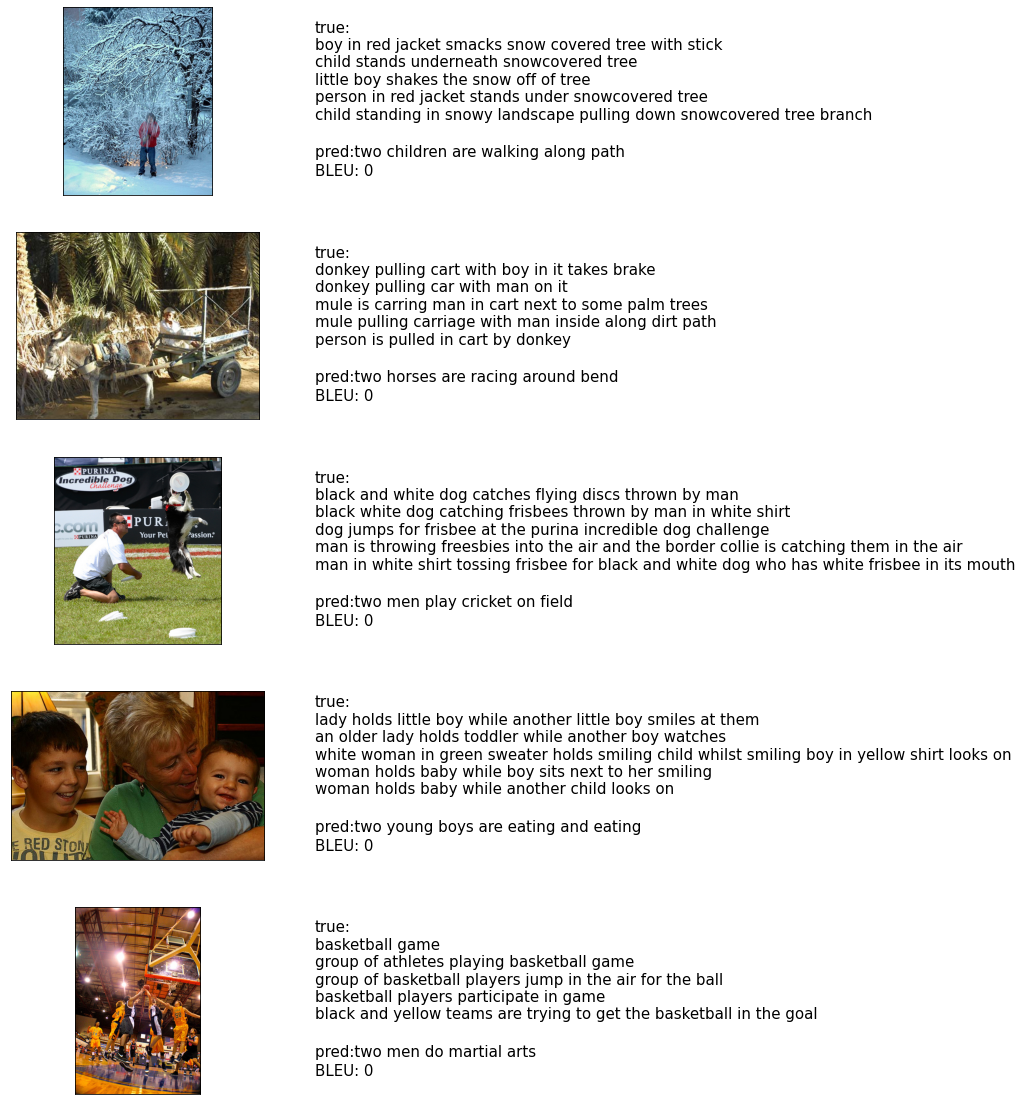

Good Caption


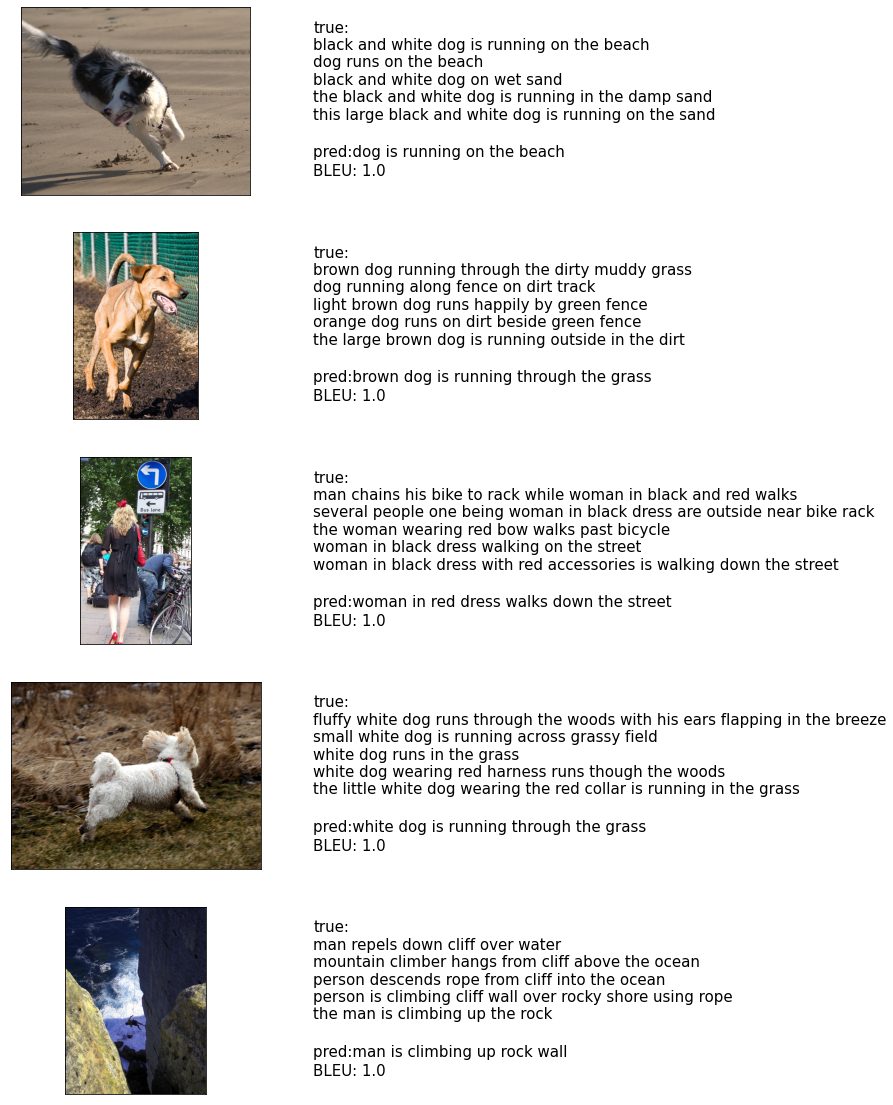

In [92]:
def plot_images(pred_bad, type='good', npic=5):
    def create_str(caption_true):
        strue = ""
        for s in list(caption_true):
            strue += "\n" + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    pred = pred_bad.copy()
    pred.sort()
    # Either get top n (good) or bottom n (bad) images to show
    if type == 'good':
       pred = pred[-npic:]
    else:
       pred = pred[:npic]
    fig = plt.figure(figsize=(10,npic*4))
    for pb in pred:
        bleu,pic,actual,caption = pb
        ## images - get image from array, reshape and display in column 1
        image = encoding_test[pic].reshape((1,2048))
        x=plt.imread(images+pic)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(x)
        count += 1
        ## Text - get true descriptions, predicted and BLEU-1 score and display in column 2
        actual = create_str(actual) # Split the 5 descriptions to separate lines
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.4,"true:" + actual,fontsize=15)
        ax.text(0,0.2,"pred:" + caption,fontsize=15)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=15)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad, 'bad')
print("Good Caption")
plot_images(pred_good, 'good')

In [0]:
Ctrl shift i put in console to keep connected
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);